# Model Training

This notebook this trains and explores various machine learning models

## Data Processing & Loading

In [ ]:
# src/data.py

import os
from pathlib import Path

import random
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T


# move up one level from the current directory
os.chdir(Path.cwd().parent)

print("Working directory set to:", Path.cwd())

Working directory set to: /Users/sarvesh/Desktop/GitHub/lego-minifigure-finder


In [ ]:
def set_seed(seed: int = 27):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(27)

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]



def _tfms(image_size=224):
    train = T.Compose([
        T.Resize(int(image_size * 1.14)),
        T.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    eval_ = T.Compose([
        T.Resize(int(image_size * 1.14)),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    return {"train": train, "val": eval_, "test": eval_}



class CSVDataset(Dataset):
    def __init__(self, csv_path, img_dir, transforms=None):
        self.df = pd.read_csv(csv_path)
        if not {"filename","label"}.issubset(self.df.columns):
            raise ValueError(f"{csv_path} must have 'filename' and 'label' columns.")
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.img_dir, str(row["filename"]))
        img = Image.open(path).convert("RGB")
        y = int(row["label"])
        if self.transforms: img = self.transforms(img)
        return img, y



def make_loaders(
    data_dir="data",
    images_subdir="images",
    batch_size=32,
    num_workers=0,         # macOS: start at 0; bump later if stable
    image_size=224,
):
    csvs = {
        "train": os.path.join(data_dir, "train.csv"),
        "val":   os.path.join(data_dir, "val.csv"),
        "test":  os.path.join(data_dir, "test.csv"),
    }
    img_dir = os.path.join(data_dir, images_subdir)
    tf = _tfms(image_size)

    ds = {
        split: CSVDataset(csvs[split], img_dir, transforms=tf["train" if split=="train" else "val"])
        for split in ["train","val","test"]
    }

    loaders = {
        "train": DataLoader(ds["train"], batch_size=batch_size, shuffle=True,
                            num_workers=num_workers),
        "val":   DataLoader(ds["val"], batch_size=batch_size, shuffle=False,
                            num_workers=num_workers),
        "test":  DataLoader(ds["test"], batch_size=batch_size, shuffle=False,
                            num_workers=num_workers),
    }
    return loaders

In [7]:
data_dir = "data"

loaders = make_loaders(data_dir=data_dir, images_subdir="images", batch_size=16)
imgs, labels = next(iter(loaders["train"]))
print(imgs.shape, labels[:8])

torch.Size([16, 3, 224, 224]) tensor([1, 0, 0, 1, 0, 0, 0, 0])


## Model Training

In [8]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt         # plots can be saved as artifacts
import numpy as np


import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import mlflow
import mlflow.pytorch                  # for logging PyTorch models

In [9]:
from mlflow import MlflowClient

client = MlflowClient(tracking_uri="http://127.0.0.1:5001")

In [10]:
# Use CUDA if available; otherwise prefer Apple MPS if present; else CPU.
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device


device(type='mps')

In [11]:
# # If you created make_loaders earlier:
# try:
#     from src.data import make_loaders
# except Exception:
#     # Fallback: assume data.py at repo root
#     from data import make_loaders

# Build loaders
loaders = make_loaders(
    data_dir="data",
    images_subdir="images",
    batch_size=32,
    num_workers=0,          # bump to 2-4 later if stable
    image_size=224
)

for k,v in loaders.items():
    print(k, len(v), "batches")


train 30 batches
val 6 batches
test 7 batches


In [44]:
CLASS_NAMES = ["not_minifig", "minifig"]
IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]
EXPORT_DIR = "models"

In [ ]:

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    preds_all, y_all = [], []

    for imgs, y in loader:
        imgs = imgs.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(logits, dim=1)
        preds_all.append(preds.detach().cpu())
        y_all.append(y.detach().cpu())

    epoch_loss = running_loss / len(loader.dataset)
    y_true = torch.cat(y_all).numpy()
    y_pred = torch.cat(preds_all).numpy()
    epoch_acc = accuracy_score(y_true, y_pred)
    return epoch_loss, epoch_acc




@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds_all, y_all = [], []

    for imgs, y in loader:
        imgs = imgs.to(device)
        y = y.to(device)

        logits = model(imgs)
        loss = criterion(logits, y)
        running_loss += loss.item() * imgs.size(0)

        preds = torch.argmax(logits, dim=1)
        preds_all.append(preds.detach().cpu())
        y_all.append(y.detach().cpu())

    epoch_loss = running_loss / len(loader.dataset)
    y_true = torch.cat(y_all).numpy()
    y_pred = torch.cat(preds_all).numpy()
    epoch_acc = accuracy_score(y_true, y_pred)
    return epoch_loss, epoch_acc, y_true, y_pred




def fit(model, loaders, epochs, lr=1e-3, weight_decay=0.0):
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = -1
    best_state = None
    history = []

    for epoch in range(1, epochs+1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, loaders["train"], criterion, optimizer, device)
        va_loss, va_acc, _, _ = evaluate(model, loaders["val"], criterion, device)
        dt = time.time() - t0

        history.append({"epoch": epoch, "train_loss": tr_loss, "train_acc": tr_acc,
                        "val_loss": va_loss, "val_acc": va_acc, "sec": dt})
        print(f"[{epoch:02d}] "
              f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
              f"val_loss={va_loss:.4f} acc={va_acc:.4f} | {dt:.1f}s")

        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

            # # NEW (Phase 4.1) — quick checkpoint
            # os.makedirs(EXPORT_DIR, exist_ok=True)
            # torch.save({
            #     "epoch": epoch,
            #     "arch": model.__class__.__name__,
            #     "model_state_dict": {k: v.detach().cpu() for k, v in model.state_dict().items()},
            #     "val_loss": va_loss,
            #     "val_acc": va_acc,
            # }, f"{EXPORT_DIR}/best_ckpt.pt")
        

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


### Defining Custom CNN Model

In [13]:
class SmallCNN(nn.Module):
    """
    Very small CNN for quick iteration.
    Input: [B, 3, 224, 224] -> 2 classes
    """

    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 112x112
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 56x56
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1,1))  # -> [B, 256, 1, 1]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

small_cnn = SmallCNN(num_classes=2)
small_cnn


SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=

## Running Model

In [14]:
mlflow.set_tracking_uri(os.path.abspath("./mlflow"))   # local folder for runs
mlflow.set_experiment("lego-minifig-test")

2025/10/08 18:30:20 INFO mlflow.tracking.fluent: Experiment with name 'lego-minifig-test' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/sarvesh/Desktop/GitHub/lego-minifigure-finder/mlflow/161657527952067457', creation_time=1759966220812, experiment_id='161657527952067457', last_update_time=1759966220812, lifecycle_stage='active', name='lego-minifig-test', tags={}>

In [ ]:
# mlflow ui --backend-store-uri ./mlflow 

In [31]:
import yaml

file_path = "notebooks/config.yaml"

with open(file_path, 'r') as file:

    config =  yaml.safe_load(file)

    print("Configuration loaded successfully! ✅")
    print(type(config))
    print(config)

Configuration loaded successfully! ✅
<class 'dict'>
{'model': 'Resnet', 'optimizer': 'Adam', 'epochs': 40, 'lr': '1e-3', 'weight_decay': 0.01}


### Custom CNN

In [43]:

with mlflow.start_run(run_name='Custom_CNN_Test_v4'):

    # logging model parameters

    mlflow.log_params(config)
    

    # model training
    model, history = fit(small_cnn, loaders, epochs=config['epochs'], lr=float(config['lr']), weight_decay=config['weight_decay'])


    # logging metrics (using 'history')
    for entry in history:
        epoch = entry['epoch']
        mlflow.log_metric('train_loss', entry['train_loss'], step=epoch)
        mlflow.log_metric('train_acc', entry['train_acc'], step=epoch)
        mlflow.log_metric('val_loss', entry['val_loss'], step=epoch)
        mlflow.log_metric('val_acc', entry['val_acc'], step=epoch)


    # evaluating model on test data
    crit = nn.CrossEntropyLoss()
    test_loss, test_acc, y_true, y_pred = evaluate(small_cnn, loaders["test"], crit, device)        
    mlflow.log_metrics({"test_loss": test_loss, "test_acc": test_acc})


[01] train_loss=0.2813 acc=0.8679 | val_loss=0.2272 acc=0.8978 | 10.7s
[02] train_loss=0.2727 acc=0.8899 | val_loss=0.2872 acc=0.9032 | 9.3s
[03] train_loss=0.2648 acc=0.8878 | val_loss=0.2190 acc=0.9140 | 9.0s
[04] train_loss=0.2602 acc=0.8941 | val_loss=0.2378 acc=0.8978 | 8.6s
[05] train_loss=0.2511 acc=0.8994 | val_loss=0.2613 acc=0.9032 | 9.2s
[06] train_loss=0.2604 acc=0.8941 | val_loss=0.2544 acc=0.8978 | 13.6s
[07] train_loss=0.2555 acc=0.8899 | val_loss=0.2445 acc=0.8817 | 8.8s
[08] train_loss=0.2644 acc=0.8920 | val_loss=0.2702 acc=0.8871 | 8.9s
[09] train_loss=0.2500 acc=0.9015 | val_loss=0.2756 acc=0.9032 | 8.4s
[10] train_loss=0.2818 acc=0.8826 | val_loss=0.2829 acc=0.8656 | 8.3s
[11] train_loss=0.2540 acc=0.9036 | val_loss=0.2532 acc=0.9032 | 8.2s
[12] train_loss=0.2484 acc=0.9004 | val_loss=0.3201 acc=0.8656 | 8.1s
[13] train_loss=0.2522 acc=0.8910 | val_loss=0.2220 acc=0.8925 | 8.5s
[14] train_loss=0.2477 acc=0.9015 | val_loss=0.3052 acc=0.8656 | 8.4s
[15] train_loss=0.

In [47]:
arch=small_cnn.__class__.__name__

print(arch)

SmallCNN


Small_CNN Test: loss=0.4681, acc=0.7870 

              precision    recall  f1-score   support

           0     0.7821    0.9524    0.8589       147
           1     0.8108    0.4348    0.5660        69

    accuracy                         0.7870       216
   macro avg     0.7965    0.6936    0.7125       216
weighted avg     0.7913    0.7870    0.7653       216



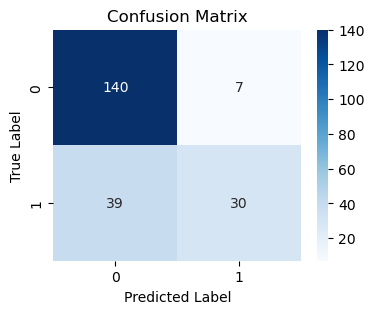

In [24]:

print(f"Small_CNN Test: loss={test_loss:.4f}, acc={test_acc:.4f} \n")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix as heatmap

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



### ResNet

In [25]:
from torchvision import models

# PyTorch 2.x API: use "weights" for pretrained
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace final layer for 2 classes
in_feats = resnet.fc.in_features
resnet.fc = nn.Linear(in_feats, 2)

# Option 1 (recommended to start): fine-tune ALL layers
for p in resnet.parameters():
    p.requires_grad = True

resnet.to(device)
resnet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
with mlflow.start_run(run_name='Resnet_v3_40epochs'):

    # logging model parameters

    mlflow.log_params(config)
    

    # model training
    model, history = fit(resnet, loaders, epochs=config['epochs'], lr=float(config['lr']), weight_decay=config['weight_decay'])


    # logging metrics (using 'history')
    for entry in history:
        epoch = entry['epoch']
        mlflow.log_metric('train_loss', entry['train_loss'], step=epoch)
        mlflow.log_metric('train_acc', entry['train_acc'], step=epoch)
        mlflow.log_metric('val_loss', entry['val_loss'], step=epoch)
        mlflow.log_metric('val_acc', entry['val_acc'], step=epoch)


    # evaluating model on test data
    crit = nn.CrossEntropyLoss()
    test_loss, test_acc, y_true, y_pred = evaluate(resnet, loaders["test"], crit, device)        
    mlflow.log_metrics({"test_loss": test_loss, "test_acc": test_acc})

[01] train_loss=0.2385 acc=0.9140 | val_loss=0.1376 acc=0.9516 | 21.7s
[02] train_loss=0.1730 acc=0.9319 | val_loss=0.1380 acc=0.9301 | 13.8s
[03] train_loss=0.1512 acc=0.9507 | val_loss=0.2843 acc=0.8387 | 14.5s
[04] train_loss=0.1355 acc=0.9518 | val_loss=0.2333 acc=0.9462 | 19.3s
[05] train_loss=0.1213 acc=0.9570 | val_loss=0.4635 acc=0.8602 | 15.2s
[06] train_loss=0.1637 acc=0.9423 | val_loss=0.4575 acc=0.8172 | 13.3s
[07] train_loss=0.1740 acc=0.9319 | val_loss=0.4242 acc=0.8817 | 13.1s
[08] train_loss=0.2304 acc=0.9078 | val_loss=0.1102 acc=0.9677 | 13.4s
[09] train_loss=0.1539 acc=0.9423 | val_loss=0.1611 acc=0.9409 | 13.2s
[10] train_loss=0.1380 acc=0.9507 | val_loss=0.1922 acc=0.9462 | 13.1s
[11] train_loss=0.1515 acc=0.9382 | val_loss=0.0615 acc=0.9731 | 13.4s
[12] train_loss=0.1138 acc=0.9654 | val_loss=0.2266 acc=0.9462 | 13.5s
[13] train_loss=0.0996 acc=0.9602 | val_loss=0.0839 acc=0.9731 | 13.7s
[14] train_loss=0.1181 acc=0.9528 | val_loss=0.1161 acc=0.9570 | 16.1s
[15] t

ResNet18 Test: loss=0.1374, acc=0.9444
              precision    recall  f1-score   support

           0     0.9530    0.9660    0.9595       147
           1     0.9254    0.8986    0.9118        69

    accuracy                         0.9444       216
   macro avg     0.9392    0.9323    0.9356       216
weighted avg     0.9442    0.9444    0.9442       216



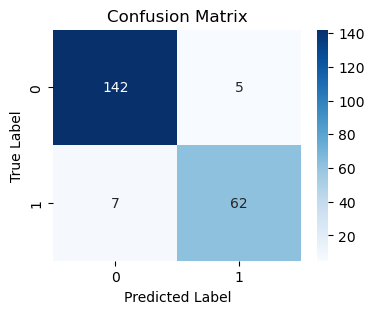

In [33]:
crit = nn.CrossEntropyLoss()
test_loss, test_acc, y_true, y_pred = evaluate(resnet, loaders["test"], crit, device)
print(f"ResNet18 Test: loss={test_loss:.4f}, acc={test_acc:.4f}")
print(classification_report(y_true, y_pred, digits=4))

# print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()